# Lark Health Healthcare Extract insight
### Capstone 2
__EDA - Exploratory data analysis__

Data science process: <br>
Problem identification > Data wrangling > __EDA__ >

***Significance*** 
1. Users in the Lark Diabetes Prevention Program (DPP) are able to interact with the Lark app in many ways. 
2. They may have conversations with the chatbot, log any meals they eat, log physical activities, and record their weights. 
3. The app also passively records how many minutes users are physically active, and sends notifications to the users periodically. 


***About Mission***
\
As DPP users interact with the app they are also exposed to content we call “missions”. 
A mission is a set of conversations about a single topic (e.g. ”Get Active”, ”Eat Well”, ”Manage Stress”) 
which requires at least 5 completed conversations with the app before a user can move to the next mission. 
The order of the missions is the same for all users.
A user cannot see more than one mission related conversation per day, so one cannot complete a mission in fewer than 5 days. 
Note that not all in-app conversations are about the user’s current mission.

***Objective***:
\
We are interested in understanding how our users interact with the app, why and when engagement drops off, what impact the mission feature has on engagement, and any other related insights this data might provide.
The data is stored in two MySQL tables:
1. user mission: Information about when a user started and finished a mis- sion.
2. agg info: User-daily engagement metrics. These engagement metrics are briefly described above.

### references: 
    1.https://towardsdatascience.com/towards-well-being-with-data-science-part-1-7f8035f73aa 
    2.https://towardsdatascience.com/towards-well-being-with-data-science-part-2-bcaf1db96064 
    3.https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python 
    4.https://towardsdatascience.com/analyse-your-health-with-python-and-apple-health-11c12894aae2

In [1]:
import seaborn as sns
from datetime import datetime
from pytz import timezone

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')

In [2]:
#Imports
import pandas as pd
import numpy as np
import plotly.express as px

In [3]:
#Initial load of files (stored locally, downloaded 9/30/2021-due 10/5/2021)
df_raw = pd.read_csv('agg_info.csv', na_values="Not Available")

display(df_raw.shape)
display(df_raw.sort_values(by="USER_ID").head(5))

(468040, 8)

,USER_ID,PST_DATE,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
337721,164106,2018-12-03,2.0,3,250.38483,90,0.0,1.0
137739,164106,2018-11-21,3.0,2,136.63333,114,1.0,1.0
137738,164106,2018-11-15,3.0,3,115.28333,98,0.0,1.0
132521,164106,2018-12-04,2.0,3,172.15000,63,0.0,1.0
265969,164106,2018-12-11,1.0,3,140.50000,100,1.0,3.0


***obervation*** we have 468040 observations with 8 features. it is pretty heavy, we need to simplify that at first to understand the data better

In [4]:
df_raw.columns
df_raw.head()
df_raw.isnull().sum()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468040 entries, 0 to 468039
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   USER_ID                    468040 non-null  int64  
 1   PST_DATE                   468040 non-null  object 
 2   NUM_CONVOS                 468040 non-null  float64
 3   NUM_ALL_MEALS              468040 non-null  int64  
 4   TOTAL_ACTIVITY_MINUTES2    468040 non-null  float64
 5   NUM_ACTIVITY_MEASUREMENTS  468040 non-null  int64  
 6   NUM_WEIGHTS                468040 non-null  float64
 7   NUM_NOTIFS                 468040 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 28.6+ MB


***obersvation*** no missing data, great!

In [5]:
# Convert Month into Datetime
df_raw['PST_DATE']=pd.to_datetime(df_raw['PST_DATE'])
df_raw.set_index('PST_DATE',inplace=True)
df_raw.describe()

,USER_ID,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
count,4.680400e+05,468040.000000,468040.000000,468040.000000,468040.000000,468040.000000,468040.000000
mean,1.435944e+06,1.286268,1.025720,64.223719,22.624470,0.205856,2.024250
std,6.840553e+04,1.897220,1.448358,68.212569,20.315924,0.650339,1.280762
min,1.641060e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.422975e+06,0.000000,0.000000,15.966666,6.000000,0.000000,1.000000
50%,1.441788e+06,1.000000,0.000000,46.283333,19.000000,0.000000,2.000000
75%,1.466286e+06,2.000000,2.000000,90.150000,35.000000,0.000000,3.000000
max,1.520428e+06,38.000000,17.000000,2245.000000,1722.000000,64.000000,7.000000


### Remove Duplicates

In [6]:
df_raw.duplicated().any()

True

In [7]:
df_users = df_raw[~df_raw.duplicated(keep='first')]
df_users.describe()

,USER_ID,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
count,4.295720e+05,429572.000000,429572.000000,429572.000000,429572.000000,429572.000000,429572.000000
mean,1.436871e+06,1.397447,1.114221,69.960676,24.649442,0.223069,1.970049
std,6.811232e+04,1.939641,1.477024,68.291617,19.994660,0.674813,1.283672
min,1.641060e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.423352e+06,0.000000,0.000000,23.250000,9.000000,0.000000,1.000000
50%,1.442738e+06,1.000000,0.000000,51.983334,22.000000,0.000000,2.000000
75%,1.466834e+06,2.000000,2.000000,95.316666,36.000000,0.000000,3.000000
max,1.520428e+06,38.000000,17.000000,2245.000000,1722.000000,64.000000,7.000000


### remove not valid data
users with no activity

In [8]:
df_users.columns

Index(['USER_ID', 'NUM_CONVOS', 'NUM_ALL_MEALS', 'TOTAL_ACTIVITY_MINUTES2',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS'],
      dtype='object')

<AxesSubplot:>

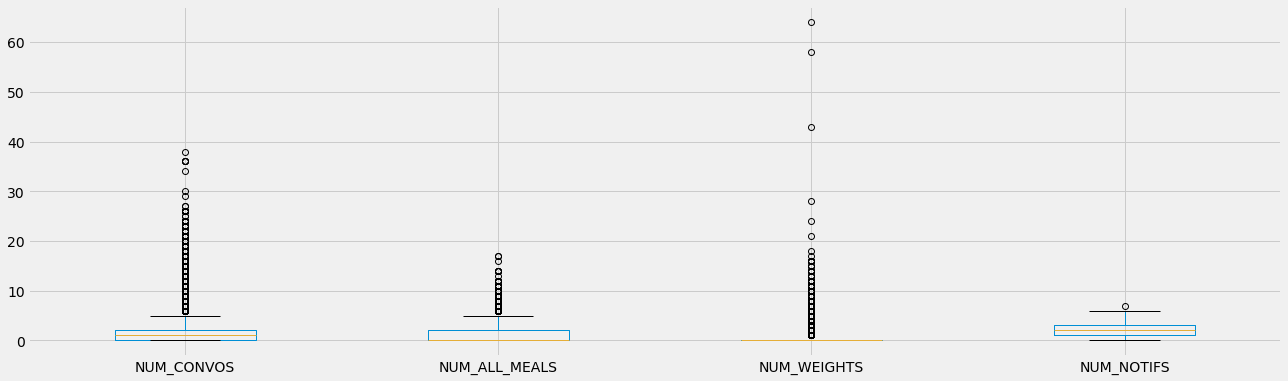

In [9]:
df_users[['NUM_CONVOS', 'NUM_ALL_MEALS',  'NUM_WEIGHTS', 'NUM_NOTIFS']].boxplot(figsize=(20,6))

<AxesSubplot:>

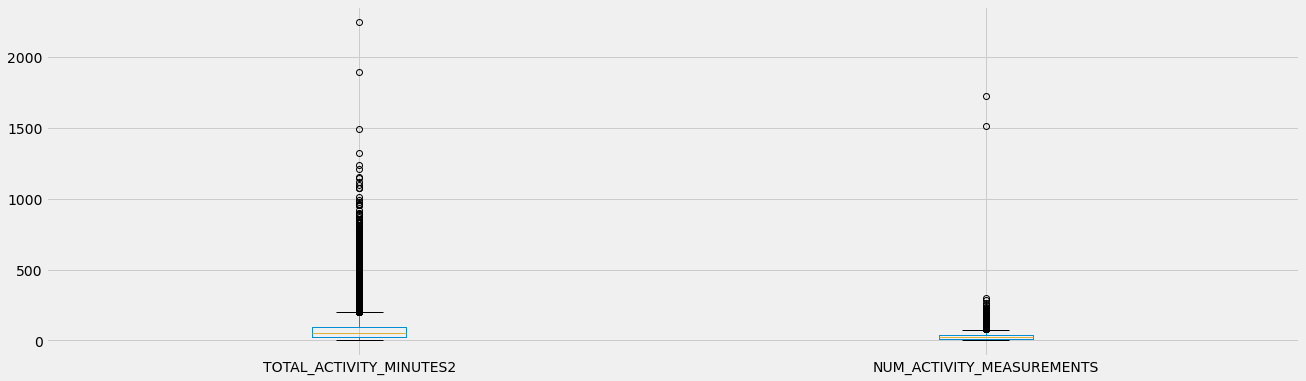

In [10]:
df_users[['TOTAL_ACTIVITY_MINUTES2','NUM_ACTIVITY_MEASUREMENTS']].boxplot(figsize=(20,6))

***Note*** Many outliers, we need to aggregate to simplify

In [11]:
df_inactive=df_users[(df_users['TOTAL_ACTIVITY_MINUTES2']==0) & (df_users['NUM_ACTIVITY_MEASUREMENTS']==0)]

In [12]:
df_inactive.describe()

,USER_ID,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
count,2.035600e+04,20356.000000,20356.000000,20356.0,20356.0,20356.000000,20356.000000
mean,1.437388e+06,1.062291,0.672480,0.0,0.0,0.168697,2.103164
std,6.184875e+04,1.760828,1.230007,0.0,0.0,0.566254,1.330284
min,1.859340e+05,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,1.422906e+06,0.000000,0.000000,0.0,0.0,0.000000,1.000000
50%,1.443794e+06,0.000000,0.000000,0.0,0.0,0.000000,2.000000
75%,1.466420e+06,2.000000,1.000000,0.0,0.0,0.000000,3.000000
max,1.520390e+06,27.000000,14.000000,0.0,0.0,13.000000,6.000000


#### thos are  inactive users who use app to track their meal ,weights, we can generate a flag as Active-Not-Active (ANA)

In [13]:
df_users['ANA']=1


<ipython-input-13-2e4c2d6f7642>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users['ANA']=1


In [14]:
df_users.loc[(df_users['TOTAL_ACTIVITY_MINUTES2']==0),'ANA']=0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [15]:
df_users.describe()

,USER_ID,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS,ANA
count,4.295720e+05,429572.000000,429572.000000,429572.000000,429572.000000,429572.000000,429572.000000,429572.000000
mean,1.436871e+06,1.397447,1.114221,69.960676,24.649442,0.223069,1.970049,0.952613
std,6.811232e+04,1.939641,1.477024,68.291617,19.994660,0.674813,1.283672,0.212465
min,1.641060e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.423352e+06,0.000000,0.000000,23.250000,9.000000,0.000000,1.000000,1.000000
50%,1.442738e+06,1.000000,0.000000,51.983334,22.000000,0.000000,2.000000,1.000000
75%,1.466834e+06,2.000000,2.000000,95.316666,36.000000,0.000000,3.000000,1.000000
max,1.520428e+06,38.000000,17.000000,2245.000000,1722.000000,64.000000,7.000000,1.000000


### 1. Check at user level aggregate one stats per user per item
overall statistics to compare different behavior among users

In [16]:
#group by user only
df_uid_sum = df_users.groupby('USER_ID').agg({'NUM_CONVOS' : sum,
                                 'TOTAL_ACTIVITY_MINUTES2' : sum,
                                 'NUM_ALL_MEALS': sum,
                                 'NUM_ACTIVITY_MEASUREMENTS': sum,
                                 'NUM_WEIGHTS': sum,
                                 'NUM_NOTIFS': sum,
                                  'ANA': np.mean
                                                   })

<AxesSubplot:>

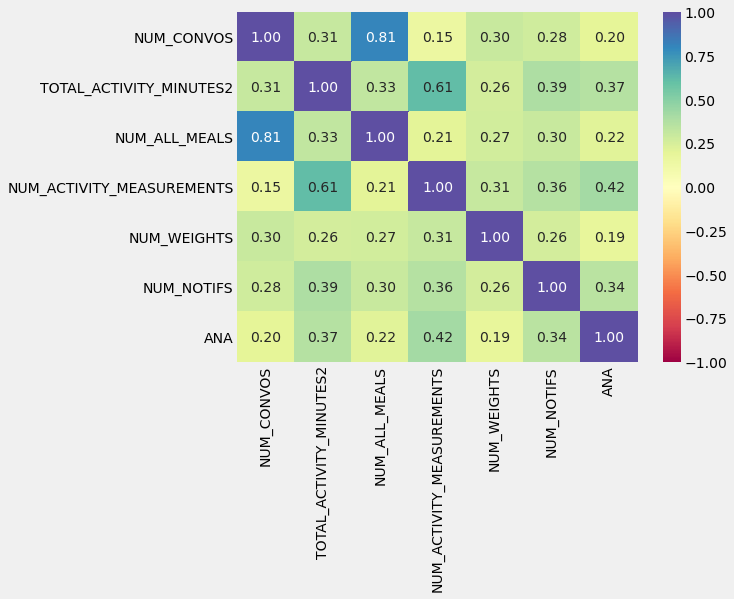

In [17]:
cm1=df_uid_sum.corr()
# heatmap
fig = plt.figure(figsize=(8,6)) 
sns.heatmap(cm1, annot=True, fmt=".2f", vmin=-1.0, vmax=+1.0, cmap='Spectral')

***Note*** few observations are 
1. Number of Meals has strong correlation with number of conversations; it could be explained by the inactive app users. We need to verify that later
2. Number of activity measurement strong correlation with number of activities minutes. 
3. while these are interesting, but they are not insightful to our questions
4. also active users have higher correlation between activity minutes, num_activity measurements and num of notification, which makes sense since it is how we created the feature.

### 2. check individual user behavior change monthly
**Main Goals are**
1. add features of engagement change (paricularly decrease) 
2.understand why the engagement decrease

In [18]:
df_W_avg = df_users.groupby('USER_ID').resample('W').agg({'NUM_CONVOS' : np.mean,
                                 'TOTAL_ACTIVITY_MINUTES2' : np.mean,
                                 'NUM_ALL_MEALS': np.mean,
                                 'NUM_ACTIVITY_MEASUREMENTS': np.mean,
                                 'NUM_WEIGHTS': np.mean,
                                 'NUM_NOTIFS': np.mean
                                                   })

In [19]:
# df_M1=df_M

df_W_avg.reset_index().set_index('PST_DATE')


,USER_ID,NUM_CONVOS,TOTAL_ACTIVITY_MINUTES2,NUM_ALL_MEALS,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
PST_DATE,,,,,,,
2018-11-04,164106,0.000000,116.533330,0.000000,33.000000,0.000000,0.000000
2018-11-11,164106,0.000000,111.370655,0.000000,77.142857,0.000000,0.000000
2018-11-18,164106,4.000000,139.176591,2.714286,93.000000,0.285714,0.857143
2018-11-25,164106,2.857143,135.454380,2.285714,91.000000,0.571429,1.571429
2018-12-02,164106,2.714286,211.573673,2.857143,83.571429,0.428571,1.428571
...,...,...,...,...,...,...,...
2019-01-06,1520390,3.666667,32.408334,2.833333,19.333333,0.000000,1.333333
2018-12-23,1520428,0.000000,84.482331,0.000000,75.500000,0.000000,0.000000
2018-12-30,1520428,1.571429,124.176190,0.571429,52.857143,0.142857,0.000000


In [20]:
df_W_avg.describe()

,NUM_CONVOS,TOTAL_ACTIVITY_MINUTES2,NUM_ALL_MEALS,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
count,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000
mean,1.294101,65.292943,1.015466,23.041951,0.214102,1.981455
std,1.434849,53.002288,1.193745,17.666602,0.438086,1.130372
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.895238,0.000000,8.714286,0.000000,1.142857
50%,1.000000,53.709524,0.571429,20.571429,0.000000,2.142857
75%,2.000000,88.785714,1.714286,34.285714,0.285714,2.857143
max,21.571429,1147.616700,11.000000,273.142857,19.600000,5.000000


In [21]:
#Generate Delta Features
df_M1=df_W_avg
df_M1['Delta_TAM']=df_M1.groupby('USER_ID')['TOTAL_ACTIVITY_MINUTES2'].diff()
df_M1['Delta_Nmeas']=df_M1.groupby('USER_ID')['NUM_ACTIVITY_MEASUREMENTS'].diff()
df_M1['Delta_NConv']=df_M1.groupby('USER_ID')['NUM_CONVOS'].diff()
df_M1['Delta_NWgts']=df_M1.groupby('USER_ID')['NUM_WEIGHTS'].diff()


In [22]:
#reset index to allow time indexing
df_M1=df_M1.reset_index().set_index('PST_DATE')

#Create holiday feature dec-Jan
df_M1['Holidays']=0
df_M1.loc[(df_M1.index.month==12 )|(df_M1.index.month==1 ) , 'Holidays'] = 1
#create ANA feature
df_M1['ANA']=1
df_M1.loc[(df_M1['TOTAL_ACTIVITY_MINUTES2']==0),'ANA']=0
df_W_avg=df_M1

In [23]:
df_W_avg.columns

Index(['USER_ID', 'NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS', 'Delta_TAM',
       'Delta_Nmeas', 'Delta_NConv', 'Delta_NWgts', 'Holidays', 'ANA'],
      dtype='object')

<AxesSubplot:xlabel='PST_DATE', ylabel='Delta_Nmeas'>

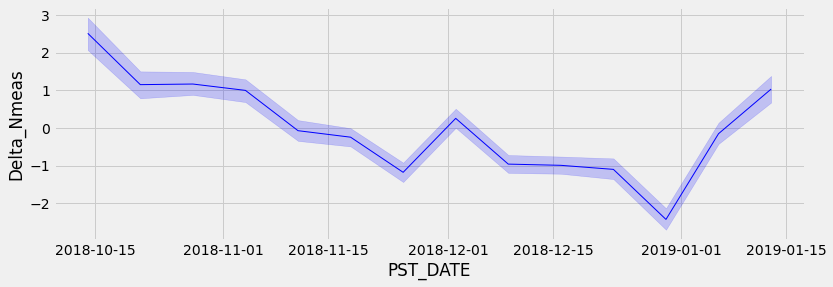

In [24]:
fig = plt.figure(figsize=(12,4)) 

sns.lineplot(data=df_W_avg['Delta_Nmeas'], color='blue', linewidth=1)


<AxesSubplot:xlabel='PST_DATE', ylabel='Delta_NConv'>

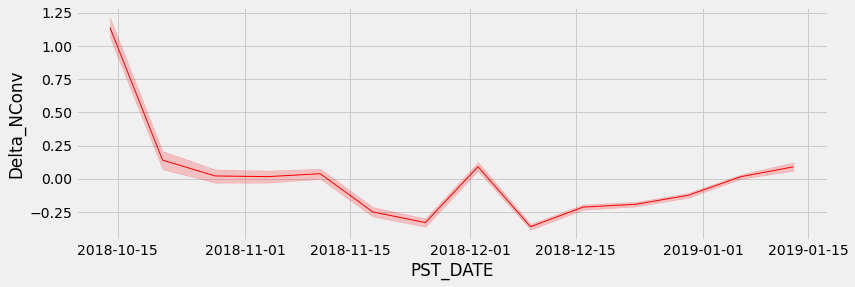

In [25]:
fig = plt.figure(figsize=(12,4)) 

sns.lineplot(data=df_W_avg['Delta_NConv'], color='red', linewidth=1)


<AxesSubplot:xlabel='PST_DATE', ylabel='Delta_NWgts'>

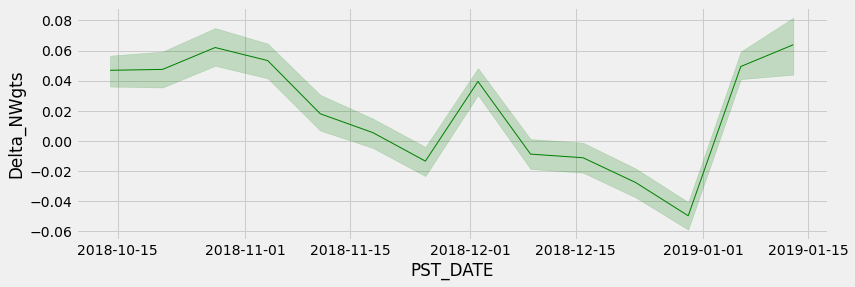

In [26]:
fig = plt.figure(figsize=(12,4)) 

sns.lineplot(data=df_W_avg['Delta_NWgts'], color='green', linewidth=1)

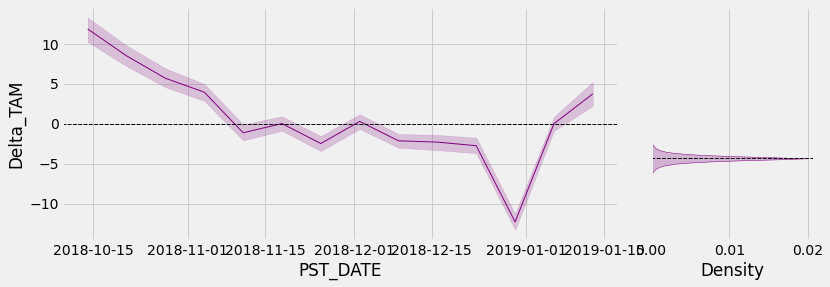

In [27]:
# differences in body mass time series and density
fig = plt.figure(figsize=(12,4)) 

# place and size subplots
ax1 = plt.subplot2grid(shape=(1, 4), loc=(0, 0), colspan=3) 
ax2 = plt.subplot2grid(shape=(1, 4), loc=(0, 3), colspan=1)

# the plots
sns.lineplot(ax=ax1, data=df_W_avg['Delta_TAM'], color='purple', linewidth=1)
sns.kdeplot(data=df_W_avg, y='Delta_TAM', color='purple', fill=True, label='', ax=ax2)

# some cosmetic changes
ax1.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
ax2.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
ax2.axes.yaxis.set_visible(False)

<AxesSubplot:>

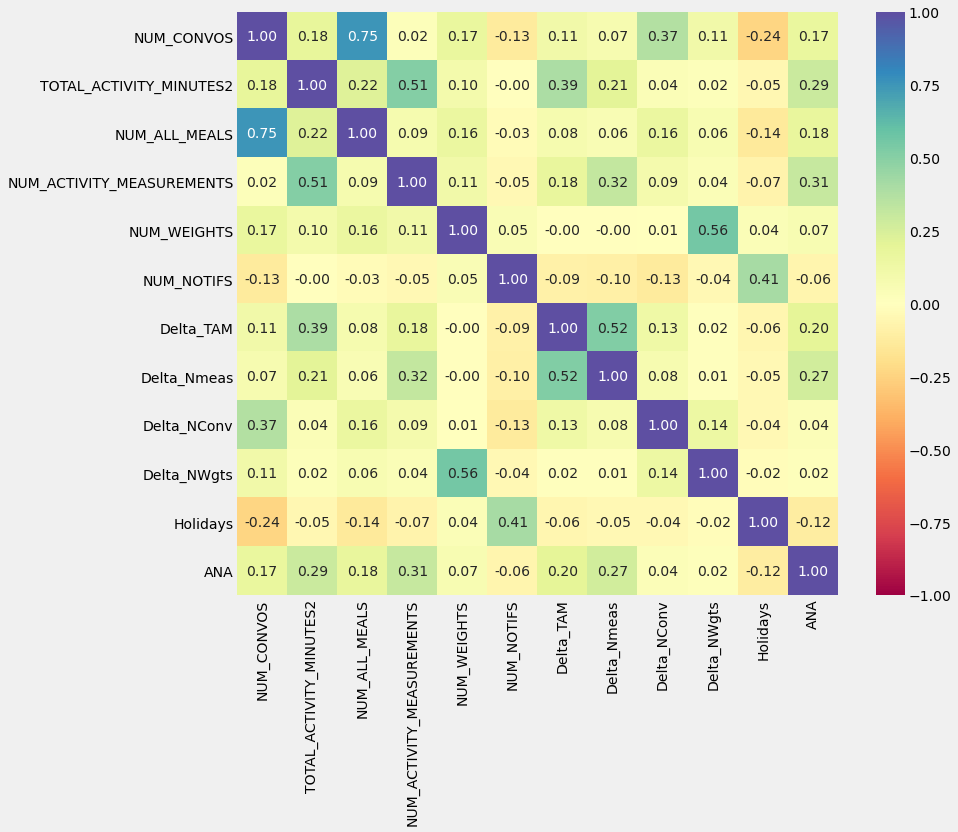

In [28]:
# correlation matrix
cm = df_W_avg.iloc[:,1:].corr()

# heatmap
fig = plt.figure(figsize=(12,10)) 
sns.heatmap(cm, annot=True, fmt=".2f", vmin=-1.0, vmax=+1.0, cmap='Spectral')

In [29]:
df_W_avg.iloc[:,1:]

Index(['NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS', 'Delta_TAM',
       'Delta_Nmeas', 'Delta_NConv', 'Delta_NWgts', 'Holidays', 'ANA'],
      dtype='object')

<Figure size 864x864 with 0 Axes>

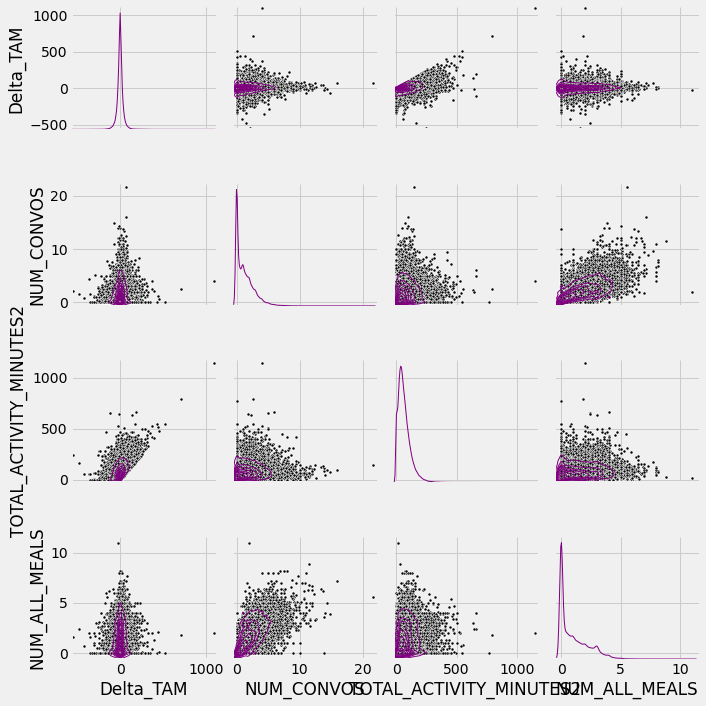

In [32]:
# pairwise plot
fig = plt.figure(figsize=(12, 12)) 

g = sns.pairplot(df_W_avg[['Delta_TAM', 'NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS']], 
             kind='kde',
             plot_kws=dict(fill=False, color='purple', linewidths=1),
             diag_kws=dict(fill=False, color='purple', linewidth=1))

# add observation dots
g.map_offdiag(sns.scatterplot, marker='.', color='black')

**Note**:  
Delta_Activity Time has linear relationship with Activity time \
Let's try to get a better metric for user engagement using PCA by combining all parameters

### PCA Analysis on Deltas

see if it is worthwhile to combine the four deltas to reduce the dimension 

In [106]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#     scale the data
X=df_W_avg[['Delta_TAM', 'Delta_Nmeas', 'Delta_NConv', 'Delta_NWgts']].dropna()
X_scaled = StandardScaler().fit_transform(X)
# compute covariance of the four delta variables not so strong correlation
features = X_scaled.T
cov_matrix = np.cov(features)
cov_matrix[:5]
# calculate eigen value and vectors
values, vectors = np.linalg.eig(cov_matrix)
values[:5]
vectors[:5]
# explained variance
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values)) 
print('explained variance {} by variables {}'.format(np.sum(explained_variances),  explained_variances))

#visualize the PCs
projected_1 = X_scaled.dot(vectors.T[0])
projected_2 = X_scaled.dot(vectors.T[1])



explained variance 1.0000000000000002 by variables [0.39047734432447356, 0.11996684127445918, 0.27786530210383886, 0.21169051229722857]


In [123]:
data=[projected_1, projected_2 ]
res = pd.DataFrame(data)
df1=res.T
df1.columns=['PC1','PC2']
df1

,PC1,PC2
0,2.898046,-3.202519
1,2.629605,-0.848728
2,-0.366996,0.139809
3,0.882685,1.987674
4,-1.489583,-0.638205
...,...,...
64494,0.703011,-0.205744
64495,-0.013804,-0.002932
64496,-0.339723,2.235822
64497,2.139954,-2.677158


<AxesSubplot:xlabel='PC1', ylabel='PC2'>

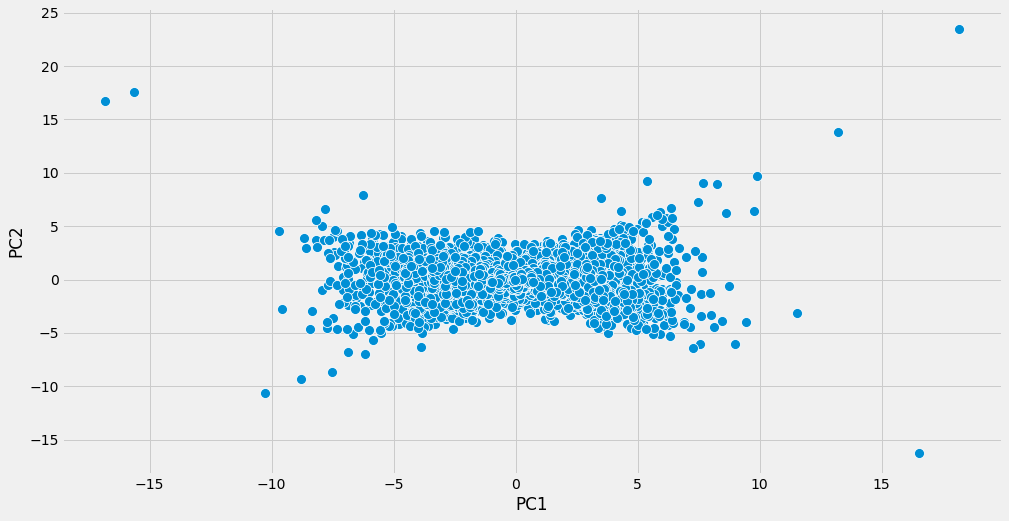

In [134]:
plt.figure(figsize=(15, 8))
sns.scatterplot(x='PC1',y='PC2', data=df1, s=100)

**Note**: Not much value add by creating PC1, PC2

In [ ]:
def pca(X)
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    from sklearn.cross_decomposition import PLSRegression
    


    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=rng)

    pcr = make_pipeline(StandardScaler(), PCA(n_components=1), LinearRegression())
    pcr.fit(X_train, y_train)
    pca = pcr.named_steps['pca']  # retrieve the PCA step of the pipeline

    pls = PLSRegression(n_components=1)
    pls.fit(X_train, y_train)
return y_train

In [30]:
import statsmodels.formula.api as smf

# OLS regression
model = smf.ols('Delta_TAM ~ 1 + NUM_CONVOS+TOTAL_ACTIVITY_MINUTES2+NUM_ALL_MEALS+NUM_ACTIVITY_MEASUREMENTS+NUM_WEIGHTS+NUM_NOTIFS+Holidays+ANA', data=df_W_avg.dropna())
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Delta_TAM   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     1706.
Date:                Fri, 01 Oct 2021   Prob (F-statistic):               0.00
Time:                        23:30:12   Log-Likelihood:            -3.1766e+05
No. Observations:               64499   AIC:                         6.353e+05
Df Residuals:                   64490   BIC:                         6.354e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   -30.7802      0.745    -41.291      0.000     -32.241     -29.319
NUM_CONVOS                    1.5480      0.153     10.132      0.000       1.249       1.847
TOTAL_ACTIVITY_MINUTES2       0.2674      0.003     91.280      0.000       0.262       0.273
NUM_ALL_MEALS                -1.8315      0.169    -10.833      0.000      -2.163      -1.500
NUM_ACTIVITY_MEASUREMENTS    -0.0865      0.009     -9.881      0.000      -0.104      -0.069
NUM_WEIGHTS                  -2.9469      0.292    -10.078      0.000      -3.520      -2.374
NUM_NOTIFS                   -2.2290      0.135    -16.483      0.000      -2.494      -1.964
Holidays                     -0.1564      0.290     -0.540      0.589      -0.724       0.411
ANA                          20.7391      0.710     29.230      0.000      19.348      22.130
==============================================================================
Omnibus:                    19682.329   Durbin-Watson:                   2.183
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           724064.212
Skew:                          -0.794   Prob(JB):                         0.00
Kurtosis:                      19.337   Cond. No.                         672.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Model is underfit, lets try to improve model fits

'NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS', 'Delta_TAM',
       'Delta_Nmeas', 'Delta_NConv', 'Delta_NWgts', 'Holidays', 'ANA'

#### define X, y

In [201]:
df_W_avg=df_W_avg.dropna()
X=df_W_avg[['NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS', 'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS']]
y=df_W_avg[['Delta_TAM']]

#### remove outliers

In [205]:
upperbound=df_W_avg[['Delta_TAM']].quantile(0.999) # upper bound is 207
y.loc[(y['Delta_TAM']>207),'Delta_TAM'] = 207 


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


#### build linear model

In [222]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion



X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

pcr = Pipeline(steps=[('scale', StandardScaler()), 
                #      ('pca', PCA(n_components=1)),
                      ('lr', LinearRegression())
                     ])
pcr.fit(X_train, y_train)
# pca = pcr.named_steps['pca']  # retrieve the PCA step of the pipeline

# pls = PLSRegression(n_components=1)
# pls.fit(X_train, y_train)


Pipeline(steps=[('scale', StandardScaler()), ('lr', LinearRegression())])

In [223]:
y_pred = pcr.predict(X_train)
y_test_pred = pcr.predict( X_test)

Text(0, 0.5, 'Predicted Delta_Total_Activity_Min')

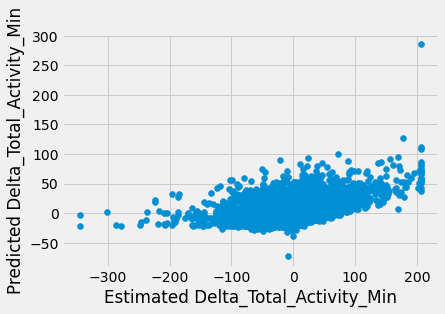

In [224]:
plt.scatter(y_test,y_test_pred)
plt.xlabel('Estimated Delta_Total_Activity_Min')
plt.ylabel('Predicted Delta_Total_Activity_Min')

In [225]:
# calculate these metrics by hand!
from sklearn import metrics
from sklearn.metrics import r2_score
print('training set')
print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
print('r2_score', r2_score(y_train, y_pred))


print('test set')
print('MAE:', metrics.mean_absolute_error(y_test,y_test_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))
print('r2_score', r2_score(y_test,y_test_pred))

training set
MAE: 22.668154465681816
MSE: 1102.0107111833497
RMSE: 33.19654667557079
r2_score 0.15095599966662632
test set
MAE: 22.444567095320913
MSE: 1051.5889230924558
RMSE: 32.42821183926822
r2_score 0.16191538227449775


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


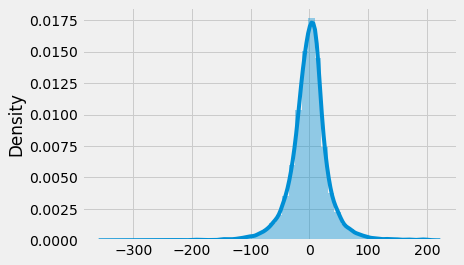

In [215]:
sns.distplot((y_test-y_test_pred),bins=50);

### Still Not a good fit, let's try randomforest

# RandomForrest Modeling

In [216]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [218]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 100, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 125, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [50, 75, 100, None], 'min_samples_split': [5], 'min_samples_leaf': [2], 'bootstrap': [True]}


In [219]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 2, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

In [227]:
%%time

rf_gs_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', rf_random)
#     ('gs', rf_gs)
])

rf_gs_pipeline.fit(X_train, y_train)



Fitting 2 folds for each of 24 candidates, totalling 48 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


CPU times: user 13.7 s, sys: 583 ms, total: 14.3 s
Wall time: 2min 3s


Pipeline(steps=[('scaler', RobustScaler()),
                ('rf',
                 RandomizedSearchCV(cv=2,
                                    estimator=RandomForestRegressor(random_state=42),
                                    n_iter=100, n_jobs=-1,
                                    param_distributions={'bootstrap': [True],
                                                         'max_depth': [50, 75,
                                                                       100,
                                                                       None],
                                                         'max_features': ['auto',
                                                                          'sqrt'],
                                                         'min_samples_leaf': [2],
                                                         'min_samples_split': [5],
                                                         'n_estimators': [50,
                           

In [228]:
best_params = rf_gs_pipeline[1].best_params_
best_params

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [229]:
# Instantiate random forest and train on tuned parameters
rf_exp = RandomForestRegressor(n_estimators=200,
                                 min_samples_split= 5,
                                 min_samples_leaf= 2,
                                 max_features='sqrt',
                                 max_depth= 50,
                                 bootstrap=True, 
                               random_state=42)

In [230]:
%%time

rf_gs_pipeline = Pipeline([
#     ('prep', preprocessor),
    ('scaler', RobustScaler()),
    ('rf', rf_exp)
#     ('gs', rf_gs)
])
# rf_exp.fit(X_train, y_train);
rf_gs_pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


CPU times: user 12.8 s, sys: 154 ms, total: 13 s
Wall time: 13 s


Pipeline(steps=[('scaler', RobustScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=50, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=200, random_state=42))])

In [231]:
# Make validation on test data
y_train_pred = rf_gs_pipeline.predict(X_train)
y_train_pred

array([-13.92805556, -20.16779955,   3.45825868, ...,   3.43649335,
        -6.57857725,  -0.92400217])

In [232]:
# Make validation on test data
y_test_pred = rf_gs_pipeline.predict(X_test)
len(y_test_pred)

16125

[0.10714355 0.38634679 0.09122783 0.23757294 0.05571376 0.12199514]


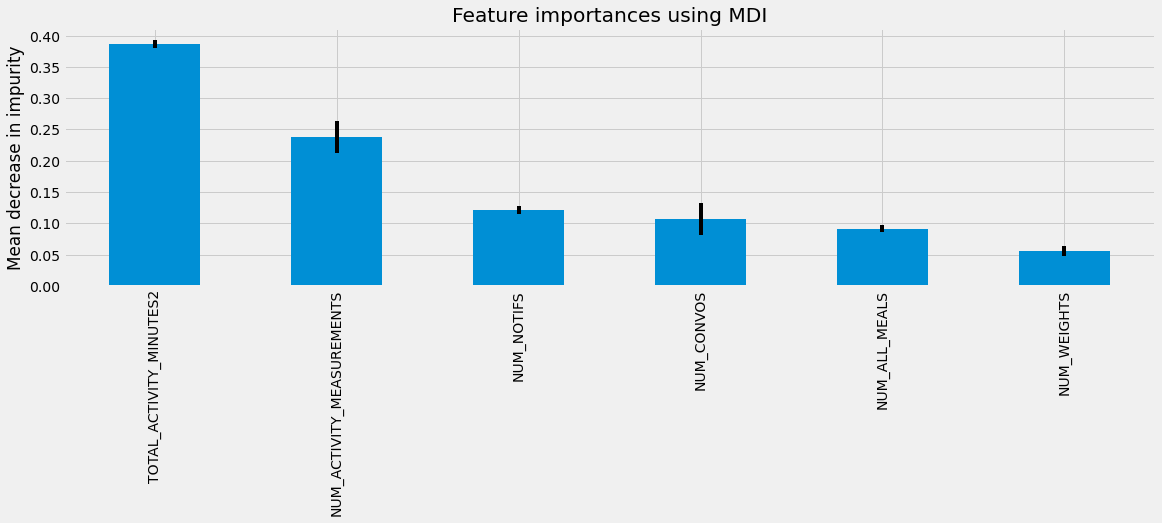

In [252]:
#Create a feature importance plot
importances = rf_gs_pipeline.steps[1][1].feature_importances_
print(importances)
feature_names=X.columns
# model.named_steps["transformer"].get_feature_names()
std = np.std([
    tree.feature_importances_ for tree in rf_gs_pipeline.steps[1][1].estimators_], axis=0)

from sklearn.inspection import permutation_importance
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.set_size_inches(18.5, 150)

Text(0, 0.5, 'Predicted TAM')

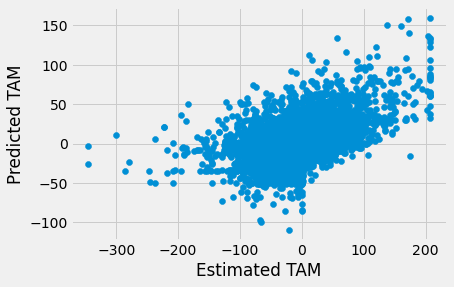

In [253]:
plt.scatter(y_test,y_test_pred)
plt.xlabel('Estimated TAM')
plt.ylabel('Predicted TAM')

In [254]:
print('training set')
print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
print('r2_score', r2_score(y_train, y_pred))


print('test set')
print('MAE:', metrics.mean_absolute_error(y_test,y_test_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))
print('r2_score', r2_score(y_test,y_test_pred))

training set
MAE: 22.668154465681816
MSE: 1102.0107111833497
RMSE: 33.19654667557079
r2_score 0.15095599966662632
test set
MAE: 22.10474159224496
MSE: 1024.2472748117941
RMSE: 32.00386343571341
r2_score 0.18370585034057196


# use resampled weekly change to identify user disengagement

In [217]:
#Select one id to investigate
df_raw1=df_raw[df_raw['USER_ID']==1212312]
df_raw1=df_raw1.reset_index().set_index('PST_DATE')


In [34]:
#group by resample and aggregate

df_W = df_raw.groupby('USER_ID').resample('W').agg({'NUM_CONVOS' : np.mean,
                                 'TOTAL_ACTIVITY_MINUTES2' : np.mean,
                                 'NUM_ALL_MEALS': np.mean,
                                 'NUM_ACTIVITY_MEASUREMENTS': np.mean,
                                 'NUM_WEIGHTS': np.mean,
                                 'NUM_NOTIFS': np.mean,
                                                   })

array([<AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>], dtype=object)

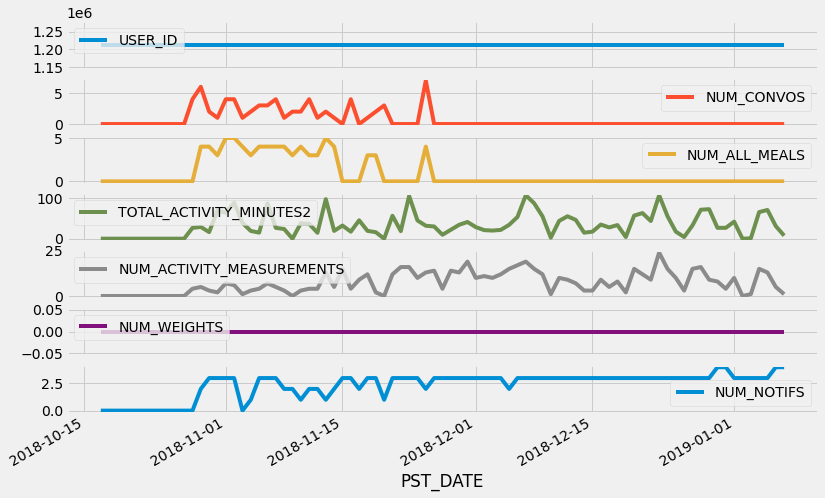

In [35]:
#line plot for raw data
df_raw1.plot(subplots=True,figsize=(12,8))


### Resampel to simplify the dataset

array([<AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>], dtype=object)

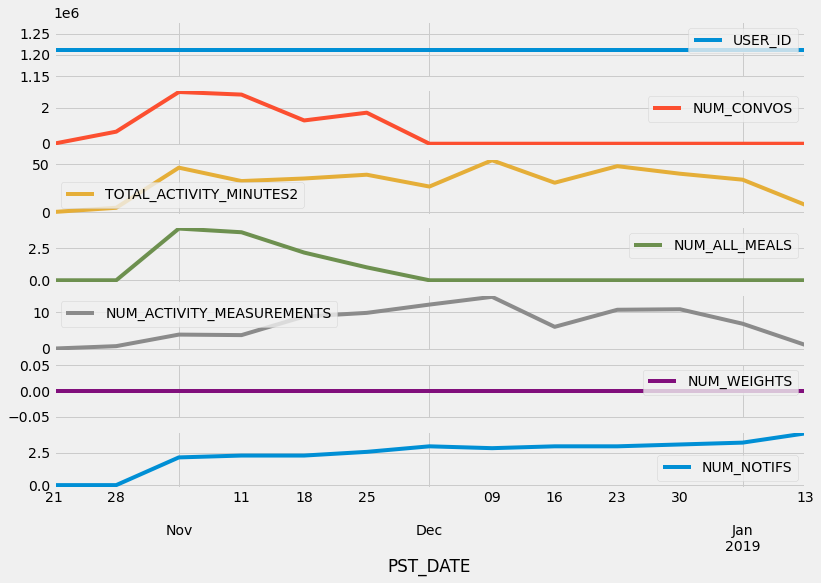

In [36]:
# reindex the dataframe so we can add features
df_W2=df_W.reset_index().set_index('PST_DATE')
df_W2=df_W2[df_W2['USER_ID']==1212312]
df_W2.plot(subplots=True,figsize=(12,8))

**Note** resampeled data keep the same trend as daily data 

### Generate user engagement metrics: Simplified Approach to see if we can generate any insights


### Metrics
1. Average_excercise_time per person per month
2. Avg Number of activity per user per month

In [37]:
df_W1=df_W2
df_W1['W_Delta_TAM']=df_W1.groupby('USER_ID')['TOTAL_ACTIVITY_MINUTES2'].diff()
df_W1['W_Delta_MEASU']=df_W1.groupby('USER_ID')['NUM_ACTIVITY_MEASUREMENTS'].diff()



In [38]:
df_W1['Holidays']=0
df_W1.loc[(df_W1.index.month==12)|(df_W1.index.month==1 ) , 'Holidays'] = 1

In [39]:
df_W1=df_W1[['USER_ID', 'NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS', 'Holidays', 'W_Delta_TAM', 'W_Delta_MEASU']]

In [40]:
df_W1.describe()

,USER_ID,NUM_CONVOS,TOTAL_ACTIVITY_MINUTES2,NUM_ALL_MEALS,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS,Holidays,W_Delta_TAM,W_Delta_MEASU
count,13.0,13.000000,13.000000,13.000000,13.000000,13.0,13.000000,13.000000,12.000000,12.000000
mean,1212312.0,0.710623,30.601557,0.835165,6.831502,0.0,2.428571,0.538462,0.623611,0.083333
std,0.0,1.080204,16.994720,1.480998,4.710381,0.0,1.183791,0.518875,20.326293,4.145425
min,1212312.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,-26.319049,-8.285714
25%,1212312.0,0.000000,26.628572,0.000000,3.714286,0.0,2.285714,0.000000,-12.774405,-1.107143
50%,1212312.0,0.000000,33.802382,0.000000,6.857143,0.0,2.857143,1.000000,-1.783333,0.833333
75%,1212312.0,1.285714,40.045238,1.000000,10.714286,0.0,3.000000,1.000000,7.646726,2.511905
max,1212312.0,2.857143,54.095238,4.000000,14.285714,0.0,4.000000,1.000000,41.944048,5.142857


***create feature of feature change with time***

In [41]:
df_W.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 77249 entries, (164106, Timestamp('2018-11-04 00:00:00')) to (1520428, Timestamp('2019-01-13 00:00:00'))
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   NUM_CONVOS                 75775 non-null  float64
 1   TOTAL_ACTIVITY_MINUTES2    75775 non-null  float64
 2   NUM_ALL_MEALS              75775 non-null  float64
 3   NUM_ACTIVITY_MEASUREMENTS  75775 non-null  float64
 4   NUM_WEIGHTS                75775 non-null  float64
 5   NUM_NOTIFS                 75775 non-null  float64
dtypes: float64(6)
memory usage: 3.8 MB


In [42]:
df_mission = pd.read_csv('user_mission.csv', na_values="Not Available")

display(df_mission.shape)
display(df_mission.sort_values(by="USER_ID").head(5))

(27983, 4)

,START_TIMESTAMP,END_TIMESTAMP,COMPLETED,USER_ID
17527,2018-12-04 16:40:00+00:00,2018-12-11 06:04:51+00:00,True,164106
17528,2018-12-25 20:02:47+00:00,2019-02-06 20:17:07+00:00,True,164106
17529,2018-11-14 06:10:21+00:00,2018-11-20 20:53:53+00:00,True,164106
17530,2018-12-17 15:20:50+00:00,2018-12-25 20:02:47+00:00,True,164106
17531,2018-11-20 20:53:53+00:00,2018-11-27 17:21:38+00:00,True,164106


***Mission data*** it is time depeneded, it tells us about when it completed and we need to join it with first table and try to understand more 

In [43]:
df_mission.columns
df_mission.head()
df_mission.isnull().sum()

START_TIMESTAMP       0
END_TIMESTAMP      3991
COMPLETED             0
USER_ID               0
dtype: int64

In [44]:
#visualize missing data
df_mission.loc[df_mission['END_TIMESTAMP'].isnull()]

,START_TIMESTAMP,END_TIMESTAMP,COMPLETED,USER_ID
1,2018-10-16 00:23:35+00:00,NaN,False,1411458
4,2018-11-10 18:43:20+00:00,NaN,False,1424093
8,2018-12-01 22:15:11+00:00,NaN,False,1418958
12,2018-11-02 17:30:14+00:00,NaN,False,1445159
13,2018-11-08 13:37:25+00:00,NaN,False,1449004
...,...,...,...,...
27937,2018-11-18 03:42:16+00:00,NaN,False,1463782
27955,2018-12-24 05:41:36+00:00,NaN,False,1208291
27963,2018-11-13 01:21:44+00:00,NaN,False,1408642
27972,2018-11-15 12:52:34+00:00,NaN,False,1458694


## Visualize Data

In [45]:
df_raw2=df_raw.sample(frac=.1, random_state=25)

<AxesSubplot:xlabel='PST_DATE'>

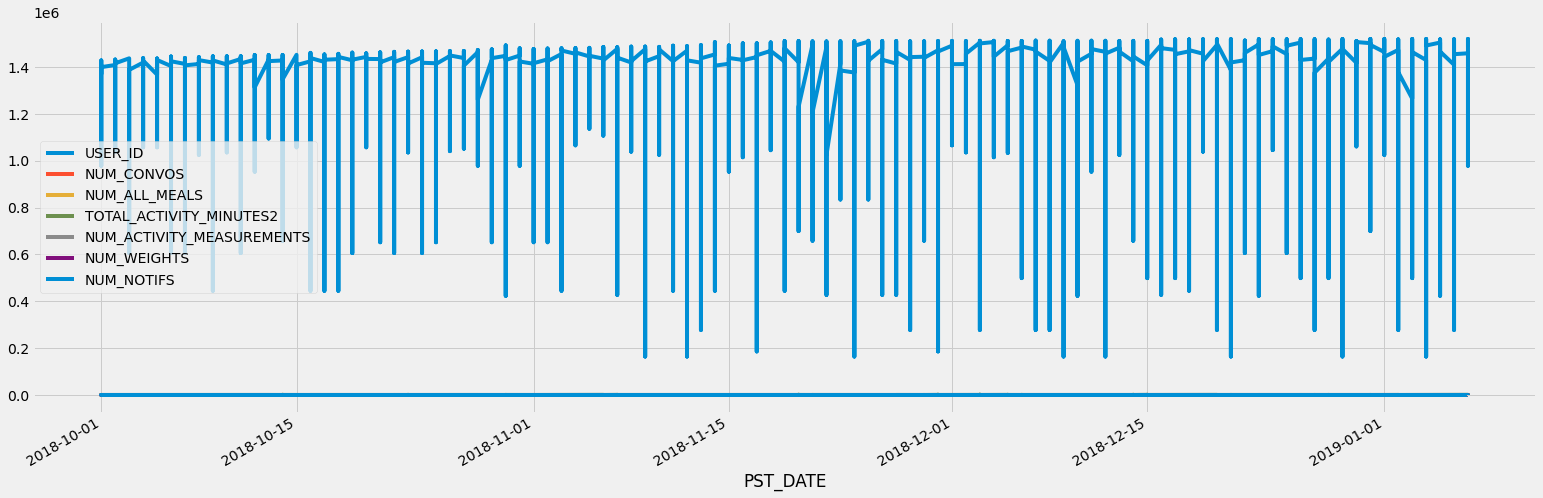

In [46]:

df_raw2.plot(figsize=(24,8))

### Brainstrom: Key questions to ask myself

Key questins: 
    1. how to predict when user start and finish a mission
    2. user_dail engagement metrics
    3. how to predict which user_id engagement drop off 
        how to define dropoff?
        what factors correlate to dropoff
    4. what impact the mission feature has on engagement any other insights?
        is the mission feature enhanced the engagement? by how much?
        

### Exploring one Random user_ID and see if we can extract any insights

first Let's simplify the question by just looking at one user

In [47]:
#How many user_ID we have: 6671 unique users
df_raw.USER_ID.value_counts(ascending=False)

1408281    99
1343122    99
1413676    99
1315787    99
1419122    99
           ..
1479194     7
1470218     7
1473061     5
1478593     4
1507407     3
Name: USER_ID, Length: 6671, dtype: int64

In [48]:
df_ru=df_raw[df_raw['USER_ID']==164106]
df_ru.describe()

,USER_ID,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
count,66.0,66.000000,66.000000,66.000000,66.000000,66.000000,66.000000
mean,164106.0,1.545455,1.818182,134.143921,76.348485,0.348485,1.924242
std,0.0,1.510800,1.323272,51.545947,25.199812,0.480142,1.406694
min,164106.0,0.000000,0.000000,48.700000,18.000000,0.000000,0.000000
25%,164106.0,0.000000,0.000000,97.016665,66.000000,0.000000,1.000000
50%,164106.0,1.000000,2.000000,119.748465,79.000000,0.000000,2.000000
75%,164106.0,2.000000,3.000000,161.368223,94.000000,1.000000,3.000000
max,164106.0,6.000000,3.000000,281.147600,118.000000,1.000000,5.000000


In [49]:
df_ru

,USER_ID,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
PST_DATE,,,,,,,
2018-12-16,164106,0.0,3,162.050000,101,1.0,5.0
2018-11-20,164106,2.0,2,88.931630,109,1.0,1.0
2018-12-18,164106,1.0,3,93.766670,94,1.0,1.0
2019-01-04,164106,0.0,0,112.833336,34,0.0,3.0
2018-12-09,164106,1.0,0,141.050000,65,1.0,4.0
...,...,...,...,...,...,...,...
2018-12-12,164106,2.0,3,274.110900,93,0.0,2.0
2018-12-01,164106,1.0,3,224.056980,77,0.0,1.0
2018-12-14,164106,1.0,3,149.051650,116,1.0,3.0


In [50]:
df_mission[df_mission['USER_ID']==164106]

,START_TIMESTAMP,END_TIMESTAMP,COMPLETED,USER_ID
17527,2018-12-04 16:40:00+00:00,2018-12-11 06:04:51+00:00,True,164106
17528,2018-12-25 20:02:47+00:00,2019-02-06 20:17:07+00:00,True,164106
17529,2018-11-14 06:10:21+00:00,2018-11-20 20:53:53+00:00,True,164106
17530,2018-12-17 15:20:50+00:00,2018-12-25 20:02:47+00:00,True,164106
17531,2018-11-20 20:53:53+00:00,2018-11-27 17:21:38+00:00,True,164106
17532,2018-11-27 17:21:38+00:00,2018-12-04 16:40:00+00:00,True,164106
17533,2018-12-11 06:04:51+00:00,2018-12-17 15:20:50+00:00,True,164106


In [51]:
features=df_ru.columns.tolist()
features.remove('USER_ID')
features

['NUM_CONVOS',
 'NUM_ALL_MEALS',
 'TOTAL_ACTIVITY_MINUTES2',
 'NUM_ACTIVITY_MEASUREMENTS',
 'NUM_WEIGHTS',
 'NUM_NOTIFS']

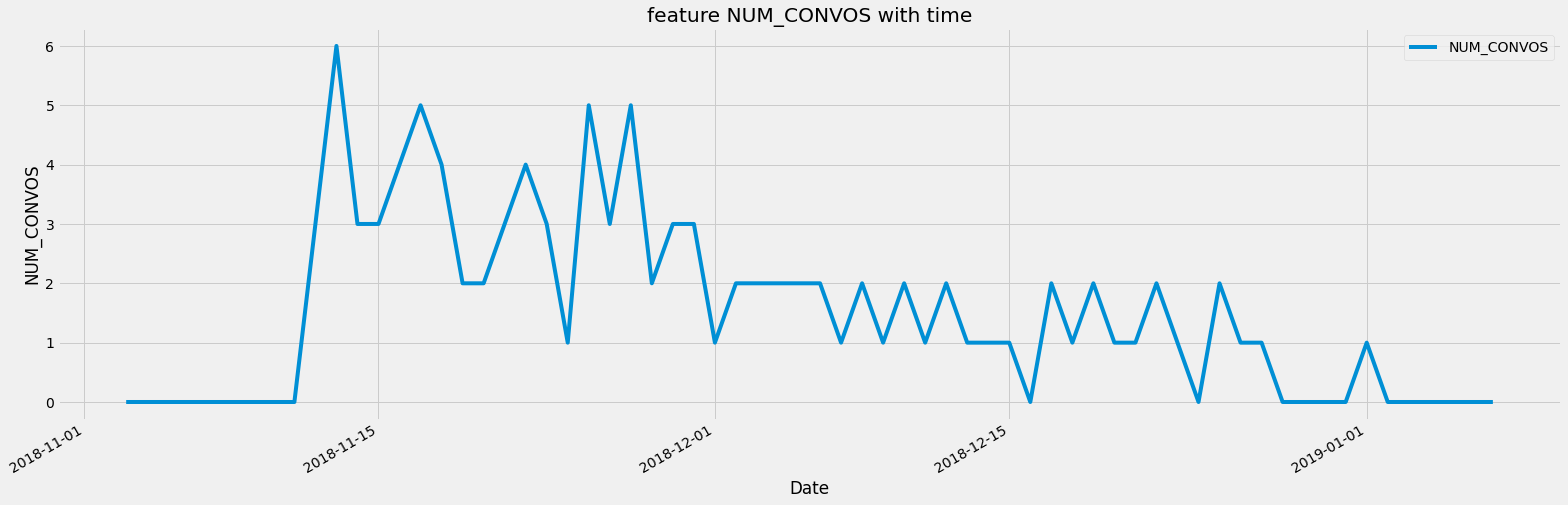

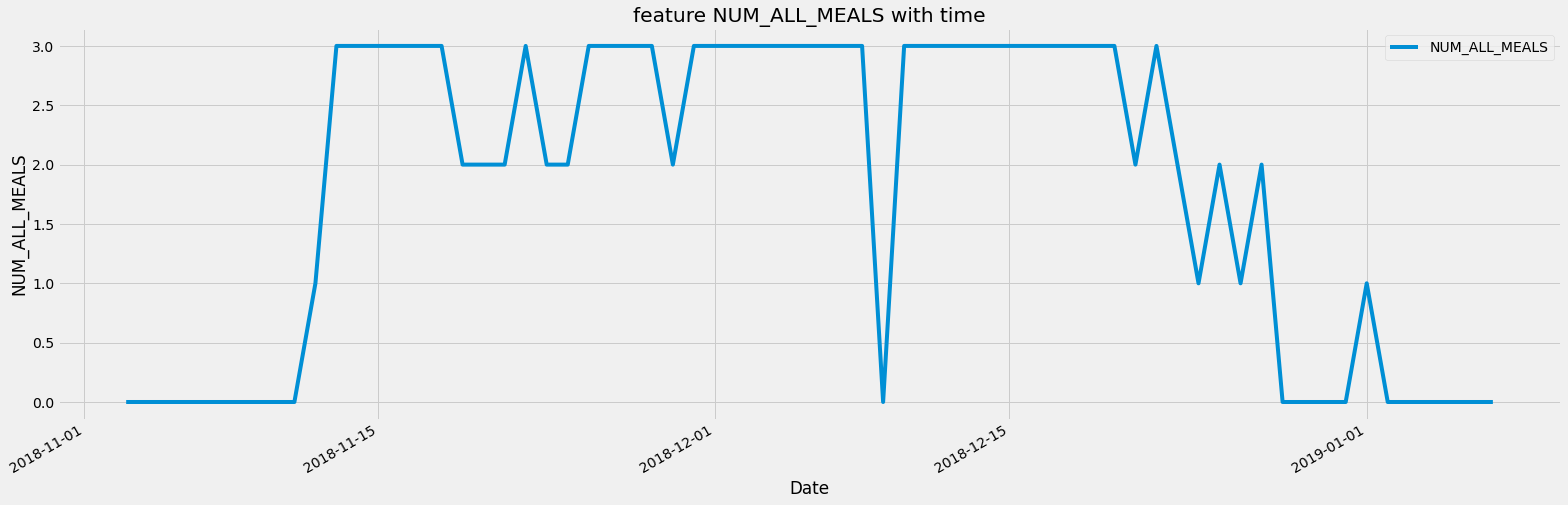

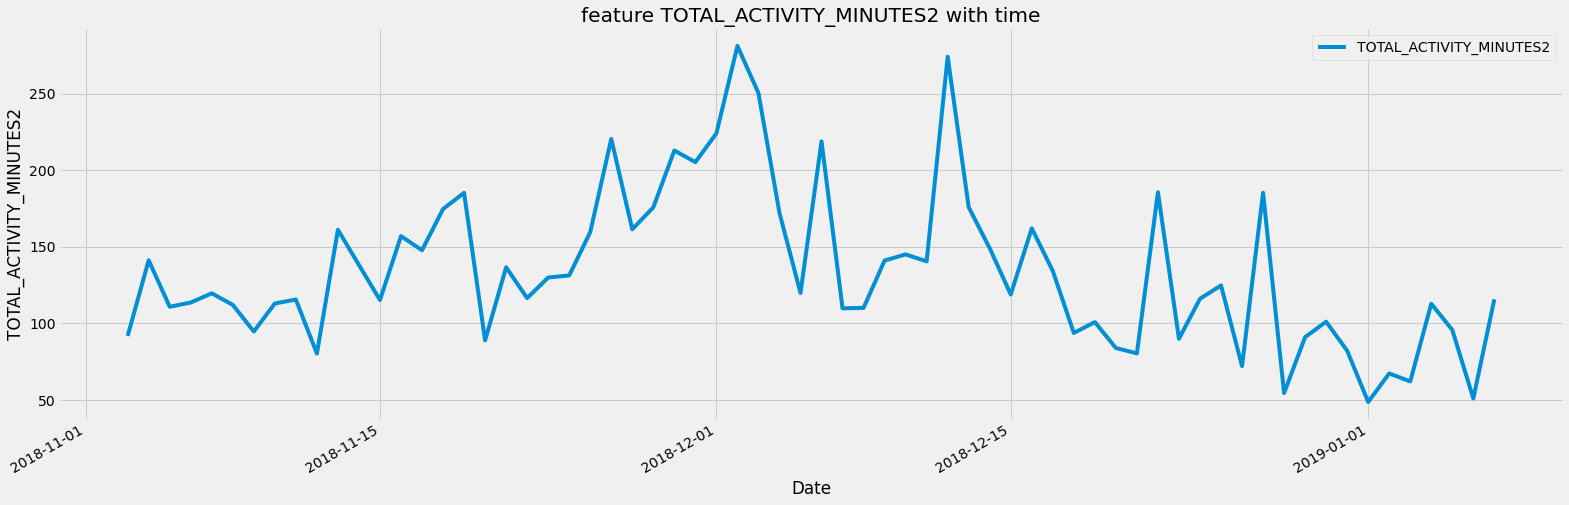

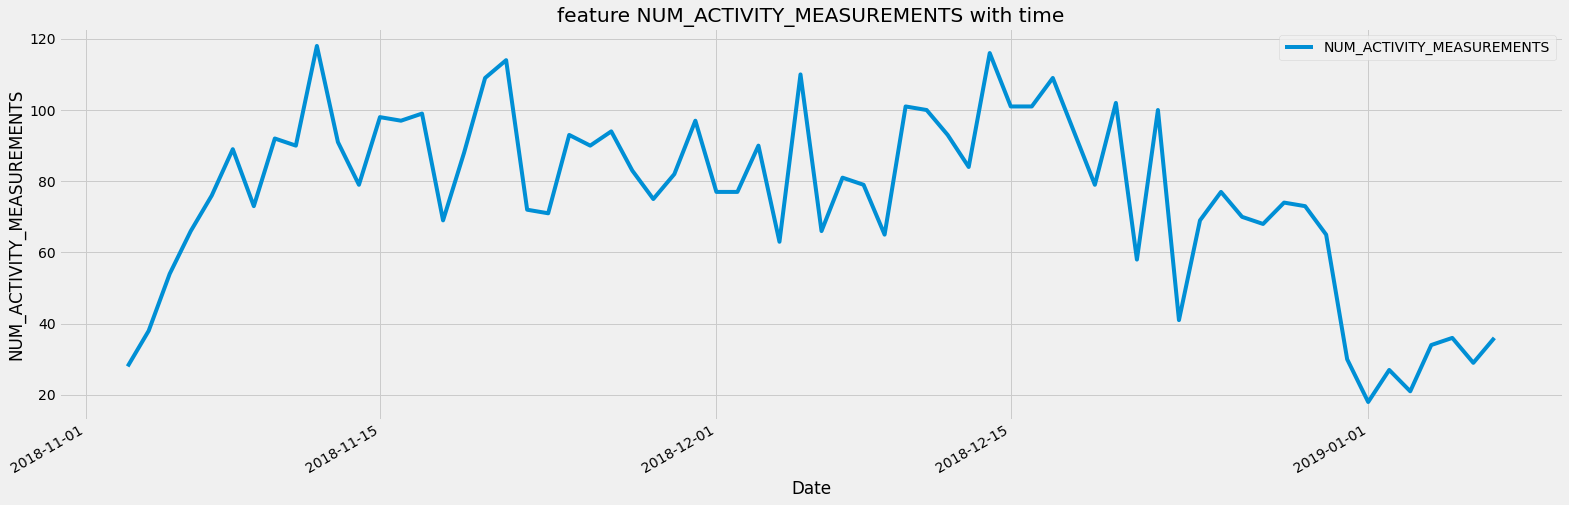

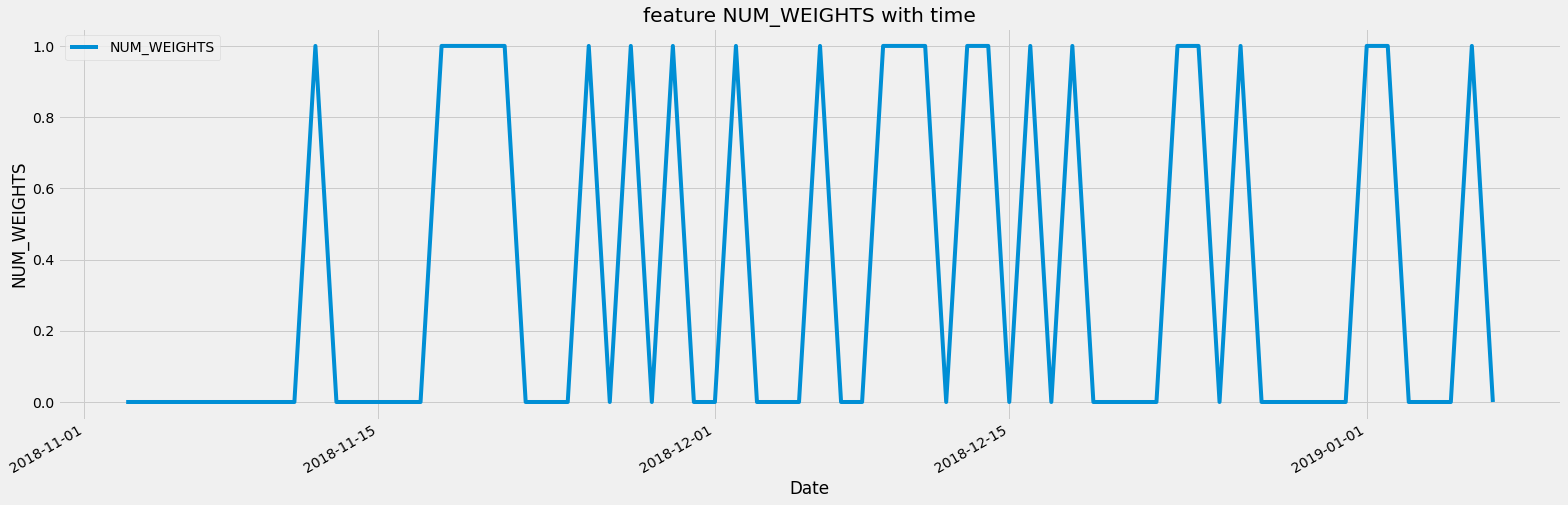

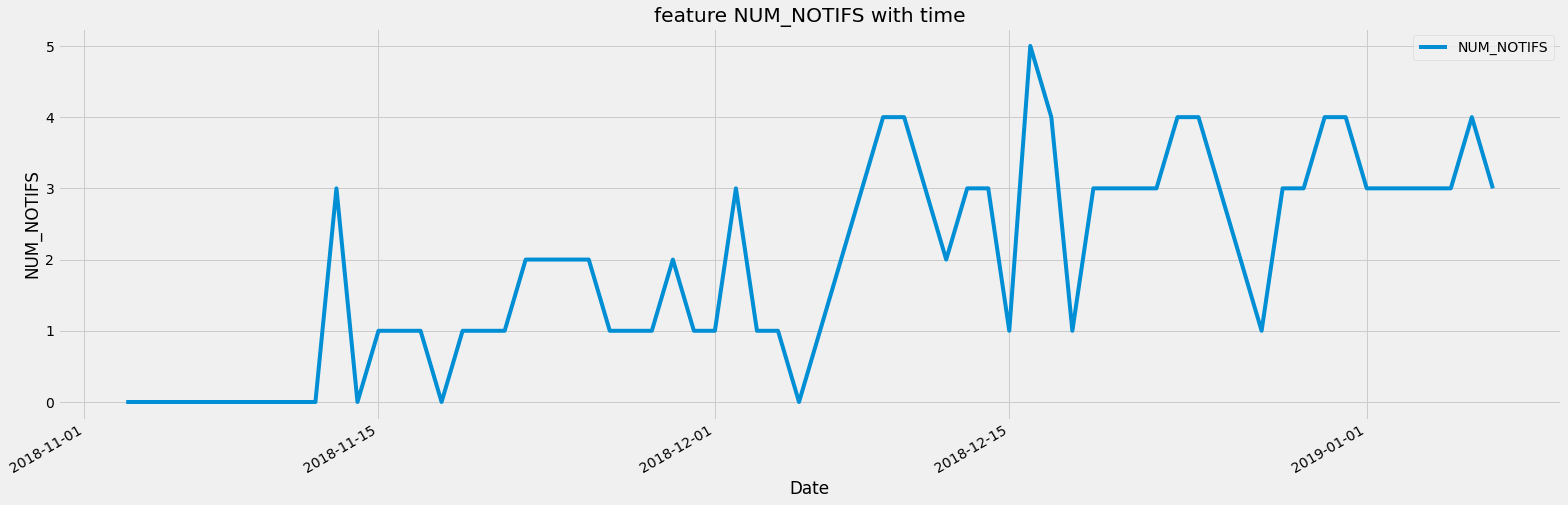

In [52]:
#A Analysis and plotting
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
# plt.style.use(‘fivethirtyeight’)
plt.style.use('fivethirtyeight')
for feature in features:
    df_ru.plot( y=feature, figsize=(24,8))
    plt.title('feature {} with time'.format(feature))
    plt.ylabel(feature)
    plt.xlabel('Date')
    

    plt.show()

***Zoom In*** Try to zoom in to see more details

In [53]:
df_ru_zoomin=df_ru[df_ru['PST_DATE']>='2018-01-01']['NUM_NOTIFS']
df_ru_zoomin.plot(x='PST_DATE', y=feature)

KeyError: 'PST_DATE'

***observation*** there might be some cyclicity in the date we need to explore more

After reviewing about the last graph, I came to realize that I have to resample the data. Why, would you ask? Remember that I mentioned that ‘startDate’ was not a daily aggregate but created whenever the device detected my movement? This means that the daily measure of steps is not consistent.
The following code resamples it to daily format:

In [ ]:
df_ru.columns

In [ ]:

### Testing For Stationarity

from statsmodels.tsa.stattools import adfuller

In [ ]:

test_result=adfuller(df_ru['TOTAL_ACTIVITY_MINUTES2'])

In [ ]:
def adfuller_test(s):
    result=adfuller(s)
    labbls = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labbls):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
# identify stationarity 
for feature in features:
    print(feature)
    adfuller_test(df_ru[feature])

***Note*** TOTAL_ACTIVITY_MINUTES2 is not stationary has trend need to pay attention to

In [ ]:
df_ru.plot( y='TOTAL_ACTIVITY_MINUTES2',figsize=(24,8))
plt.title('feature {} with time'.format('TOTAL_ACTIVITY_MINUTES2'))
plt.ylabel(feature)
plt.xlabel('Date')

***Note*** There are peaks around christmas time, maybe it is relate to holiday. user has more time to excercise

### Auto Correlation

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Autocorrelation and partical autocorrelation in the Steps dataset
# Two plots on one sheet
%matplotlib inline
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df_ru['TOTAL_ACTIVITY_MINUTES2'], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df_ru['TOTAL_ACTIVITY_MINUTES2'], lags=20, ax=ax2)



***Note*** Not many dataset are outside of the highlighted blue area. This is good. only lag 8 has some autocorrelation

### Prediction
I applied smoothers to remove some of the huge spikes in the data and here is the before the prediction. Notice how the dataset is a lot more ‘flatter’ now:

In [ ]:
# For non-seasonal data
#p=1, d=1, q=0 or 1
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# ARIMA forecasts
# Setting up
steps_new=df_ru['TOTAL_ACTIVITY_MINUTES2']
model_AR4 = ARIMA(steps_new, order=(8, 0, 0)) 
results_AR4 = model_AR4.fit()
print(results_AR4.summary())
# model 1
# Fcast400 = results_AR4.predict()
# setup 2
# Arima(2,0,2) model and its fitted values
model303 = ARIMA(steps_new, order=(3, 0, 3)) 
results_M303 = model303.fit()
print(results_M303.summary())
# model 2
# Fcast303 = results_M303.predict()

In [ ]:
# line plot of residuals
residuals = pd.DataFrame(results_AR4.resid)
residuals.plot()

# density plot of residuals
residuals.plot(kind='kde')

# summary stats of residuals
print(residuals.describe())

**Note** the residual is fine, with mean close to 0

In [ ]:

model=ARIMA(df_ru['TOTAL_ACTIVITY_MINUTES2'],order=(1,1,1))
model_fit=model.fit()

model_fit.summary()

In [ ]:
df_ru['forecast']=model_fit.predict(dynamic=True)
df_ru[['TOTAL_ACTIVITY_MINUTES2','forecast']].plot(figsize=(12,8))
